# **MegaMart Customer Segmentation Analysis (Cluster Analysis)**

APLICACIÓN DE MÉTODOS MULTIVARIADOS EN CIENCIA DE DATOS

MA2003B.601

**Authors:**
* Mauricio Loera Abundis
* Gerardo Javier López García
* Emilio Guillen Ramírez

### **Section 1: Project Setup & Data Loading**

In [31]:
# Import necessary libraries for data analysis, visualization, and clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

In [32]:
# Load the retail customer data and perform initial exploration
df = pd.read_csv('../data/retail_customer_data.csv', index_col = 0)

print("\n=============================================================\n")
print("DATASET SHAPE:", df.shape)
print("\n=============================================================\n")
print("\nDATASET INFO:")
print(df.info())
print("\n=============================================================\n")
print("\nFIRST 5 CUSTOMERS:")
display(df.head())
print("\n=============================================================\n")
print("\nDESCRIPTIVE STATISTICS:")
display(df.describe())
print("\n=============================================================\n")

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)



DATASET SHAPE: (3000, 9)



DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, CUST_0001 to CUST_3000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   monthly_transactions     3000 non-null   float64
 1   avg_basket_size          3000 non-null   float64
 2   total_spend              3000 non-null   float64
 3   avg_session_duration     3000 non-null   float64
 4   email_open_rate          3000 non-null   float64
 5   product_views_per_visit  3000 non-null   float64
 6   return_rate              3000 non-null   float64
 7   customer_tenure_months   3000 non-null   int64  
 8   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 234.4+ KB
None



FIRST 5 CUSTOMERS:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
customer_id,,,,,,,,,
CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18





DESCRIPTIVE STATISTICS:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


#### **INITIAL FINDINGS:**
* The dataset contains **3,000 active customers**.
* There are **9 behavioral variables** (excluding customer_id).
* There are **no missing values**.
* The variables are on different scales (`total_spend` is in thousands, while `return_rate` is a decimal), indicating that **standardization** will be required.

### **Section 2: Exploratory Data Analysis (EDA)**

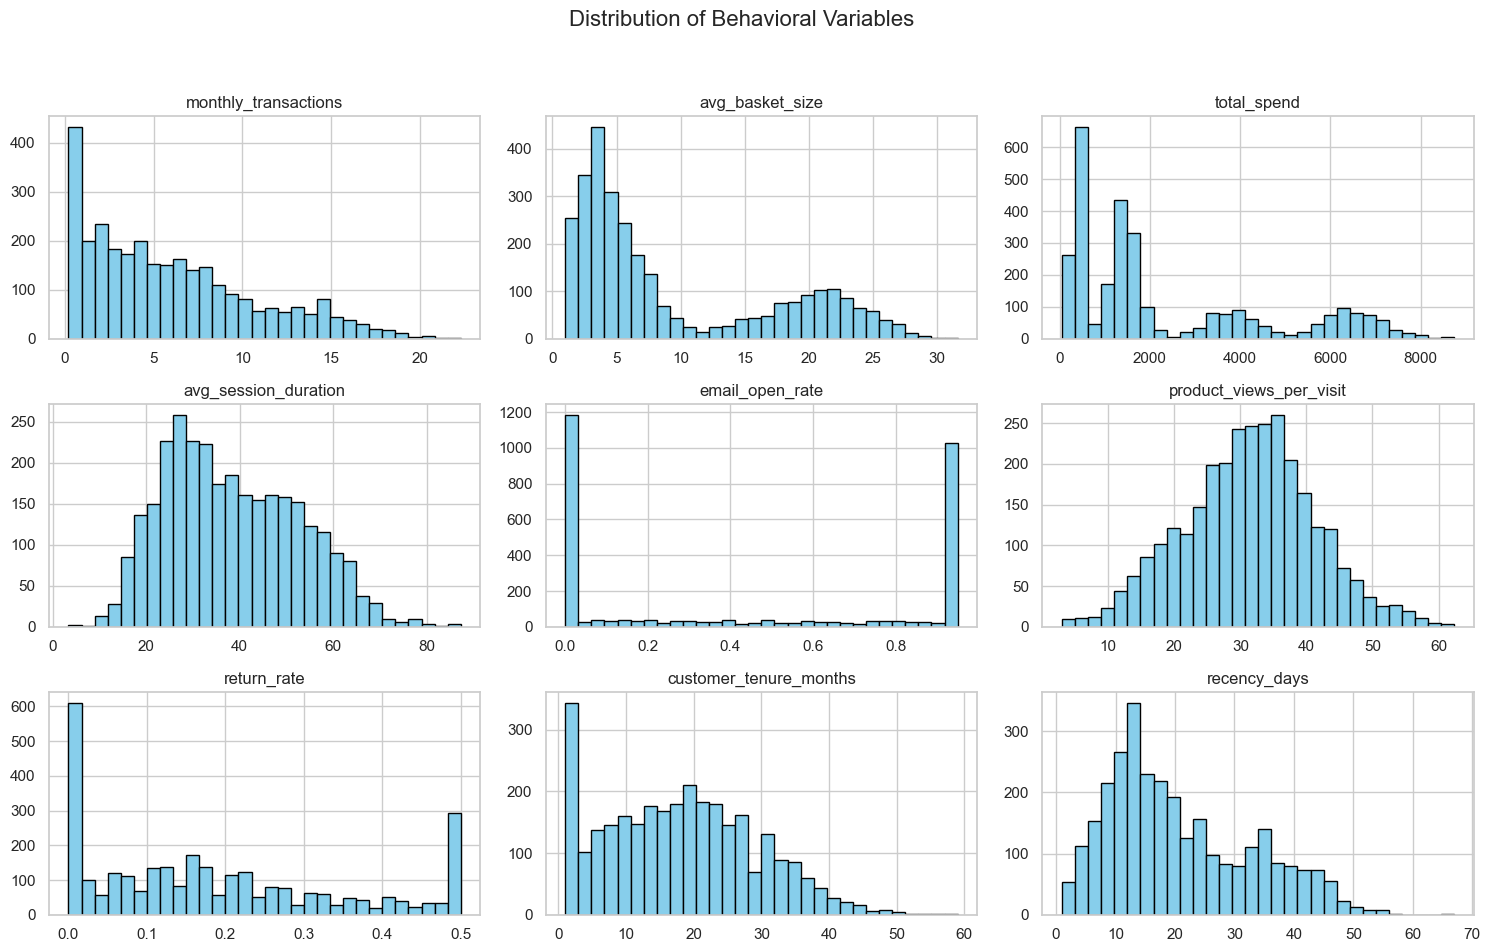

In [33]:
# VARIABLE DISTRIBUTIONS
# Visualize the distribution of each behavioral variable
df.hist(bins=30, figsize=(15, 10), layout=(3, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Behavioral Variables', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

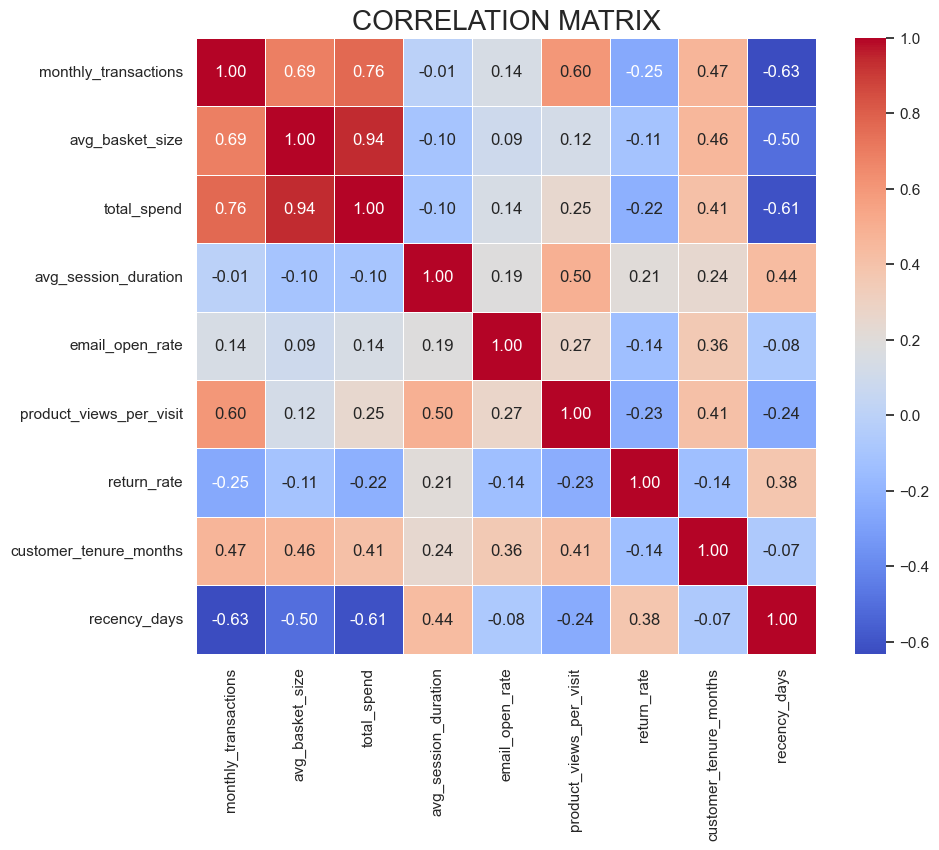


STRONGEST CORRELATIONS:
avg_basket_size <-> total_spend: 0.941
monthly_transactions <-> total_spend: 0.764
monthly_transactions <-> avg_basket_size: 0.691
monthly_transactions <-> recency_days: -0.632
total_spend <-> recency_days: -0.612


In [34]:
# CORRELATION ANALYSIS
# Compute and visualize the correlation matrix to understand relationships between variables
plt.figure(figsize = (10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = 0.5)
plt.title('CORRELATION MATRIX', fontsize=20)
plt.show()

print("\nSTRONGEST CORRELATIONS:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((
            corr_matrix.columns[i],
            corr_matrix.columns[j],
            corr_matrix.iloc[i, j]
        ))
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs_sorted[:5]:
    print(f"{var1} <-> {var2}: {corr:.3f}")

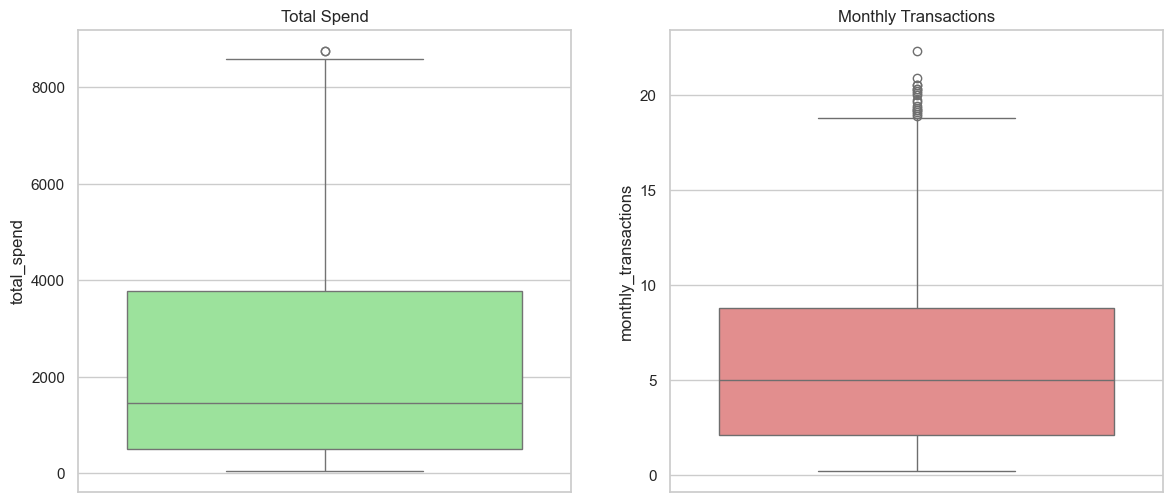

In [35]:
# OUTLIER DETECTION
# Check for outliers in key variables using boxplots
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y = df['total_spend'], color = 'lightgreen')
plt.title('Total Spend')

plt.subplot(1, 2, 2)
sns.boxplot(y =df['monthly_transactions'], color = 'lightcoral')
plt.title('Monthly Transactions')

plt.show()

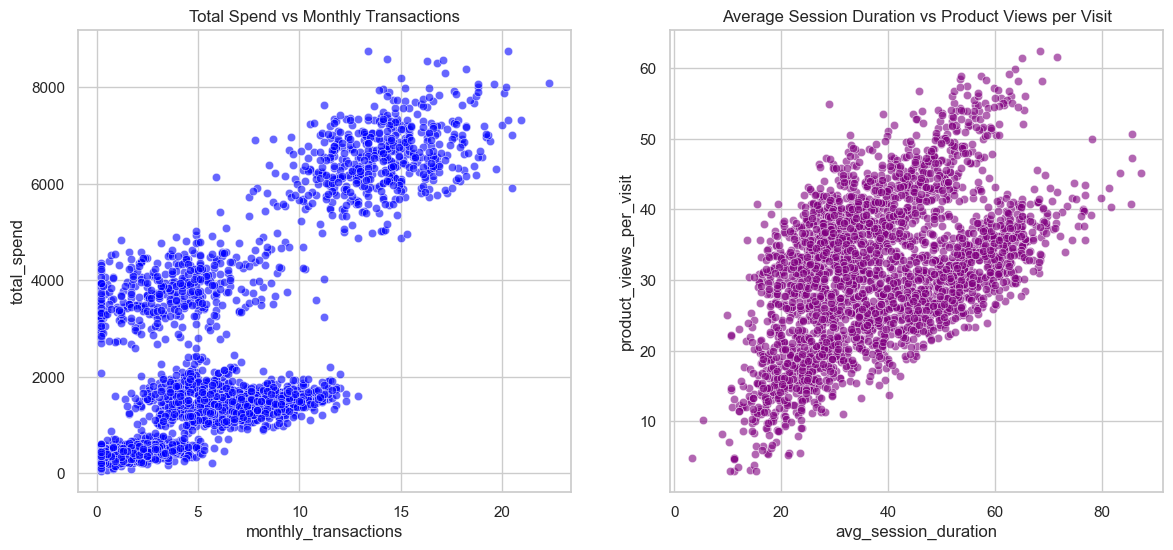

In [36]:
# SCATTER PLOTS
# Explore relationships between pairs of variables
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data = df, x = 'monthly_transactions', y = 'total_spend', color = 'blue', alpha = 0.6)
plt.title('Total Spend vs Monthly Transactions')

plt.subplot(1, 2, 2)
sns.scatterplot(data = df, x = 'avg_session_duration', y = 'product_views_per_visit', color = 'purple', alpha = 0.6)
plt.title('Average Session Duration vs Product Views per Visit')

plt.show()

### **Section 3: Data Preprocessing**

In [37]:
# CHECK FOR MISSING DATA
# Ensure there are no missing values in the dataset
print("Missing values:", df.isnull().sum().sum())

Missing values: 0


In [38]:
# STANDARDIZATION
# Standardize the data to ensure all variables have mean 0 and std 1 for fair clustering
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_array, columns = df.columns, index = df.index)

print("Data standardized: mean approx 0, std approx 1 for all variables")
display(df_scaled.describe().round(4))

Data standardized: mean approx 0, std approx 1 for all variables


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000,3000.0000
mean,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
std,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002,1.0002
min,-1.2168,-1.0660,-1.0309,-2.4450,-1.0384,-2.8466,-1.1457,-1.5046,-1.6328
25%,-0.8190,-0.7770,-0.8258,-0.7983,-1.0384,-0.6484,-0.8991,-0.7929,-0.8031
50%,-0.2118,-0.4881,-0.4054,-0.1320,-0.2427,0.0241,-0.2212,0.0078,-0.2224
75%,0.5839,0.9849,0.6250,0.7646,1.1848,0.6465,0.6416,0.7195,0.7109
max,3.4107,2.7783,2.8377,3.4091,1.1848,3.1158,1.9359,3.6553,3.8428


Clustering algorithms like K-Means and Hierarchical Clustering calculate distances between data points. If variables are not on the same scale, variables with large magnitudes (like `total_spend`) will disproportionately influence the model compared to small variables (like `return_rate`).

We will use **StandardScaler** to transform the data so that each variable has a mean of 0 and a standard deviation of 1.

### **Section 4: Hierarchical Clustering Analysis**

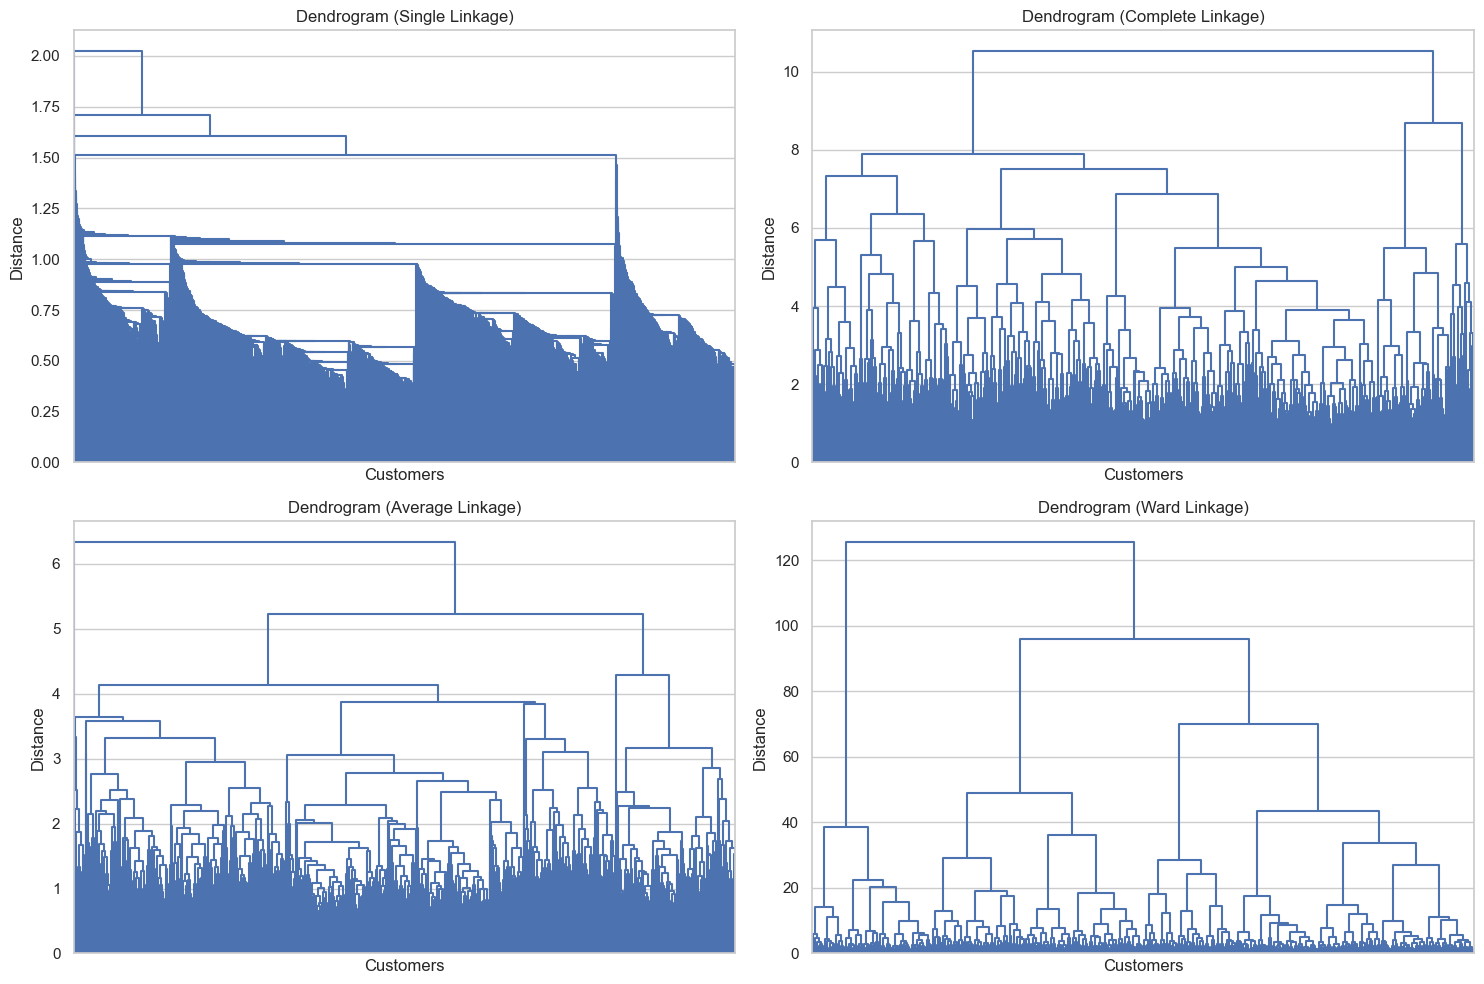

In [39]:
# COMPUTE LINKAGE MATRICES AND CREATE DENDOGRAMS
# Generate dendrograms for different linkage methods to visualize hierarchical clustering
linkage_methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i+1)

    Z = linkage(df_scaled, method=method)

    dendrogram(Z, no_labels=True, color_threshold=0)
    plt.title(f'Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Customers')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

**Dendrogram Interpretation**

- **Most suitable linkage:**  
  Ward’s linkage is the most appropriate for this customer segmentation task. It produces compact, spherical clusters and avoids the long, thin chains seen in single linkage.

- **Where to cut the dendrogram:**  
  In the Ward dendrogram, there is a clear jump in merge height near the top. Cutting the tree **just below this big jump** (around a moderate distance level) would yield **about 4 clusters**, which is consistent with the K-Means results.  
  The **height of each merge** represents the **dissimilarity** (distance) between the clusters being joined:  
  - Low merge height → clusters being merged are very similar.  
  - High merge height → clusters are quite different, so merges near the top correspond to combining already well-separated groups.

- **Chaining effect:**  
  The chaining effect occurs when clusters are formed by successively linking points that are only locally close to at least one existing point, creating **long, string-like clusters** instead of compact groups.  


### **Section 5: Determining Optimal Number of Clusters (Hierarchical)**

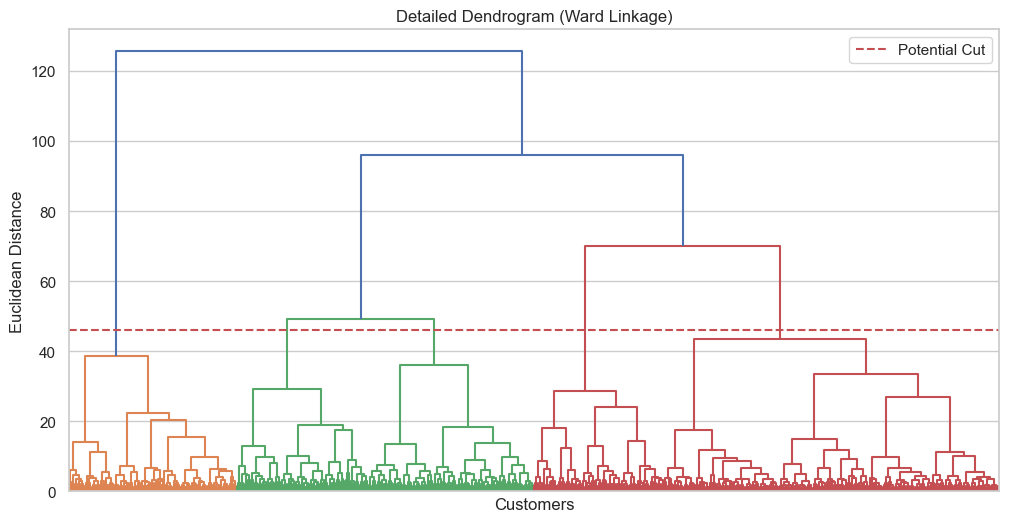

Hierarchical Clustering Performance:
k=3: Silhouette Score = 0.2948
k=4: Silhouette Score = 0.3157
k=5: Silhouette Score = 0.3003
k=6: Silhouette Score = 0.2475
k=5: Silhouette Score = 0.3003
k=6: Silhouette Score = 0.2475


,k,Silhouette Score
0,3,0.294781
1,4,0.315700
2,5,0.300267
3,6,0.247512


In [40]:
# FOCUSED DENDOGRAM
# Create a detailed dendrogram for Ward linkage to determine optimal clusters
plt.figure(figsize=(12, 6))
Z_ward = linkage(df_scaled, method='ward')
dendrogram(Z_ward, no_labels=True)
plt.title('Detailed Dendrogram (Ward Linkage)')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.axhline(y=46, color='r', linestyle='--', label='Potential Cut')
plt.legend()
plt.show()

# EXTRACT CLUSTERS AND CALCULATE SILHOUETTE SCORES
# Evaluate different numbers of clusters using silhouette scores
k_values = [3, 4, 5, 6]
h_silhouette_scores = []

print("Hierarchical Clustering Performance:")
for k in k_values:
    labels = fcluster(Z_ward, t=k, criterion='maxclust')
    score = silhouette_score(df_scaled, labels)
    h_silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

h_results = pd.DataFrame({'k': k_values, 'Silhouette Score': h_silhouette_scores})
display(h_results)

### **Section 6: K-Means Clustering - Elbow Method**

K-Means Results for different k:


,k,Inertia,Silhouette
0,2,19065.449551,0.344552
1,3,14397.532007,0.297391
2,4,11944.281914,0.317311
3,5,10616.552893,0.269579
4,6,9517.151689,0.279059
5,7,8736.425526,0.281452
6,8,7999.739224,0.278445
7,9,7454.649034,0.266246
8,10,6981.049230,0.270829


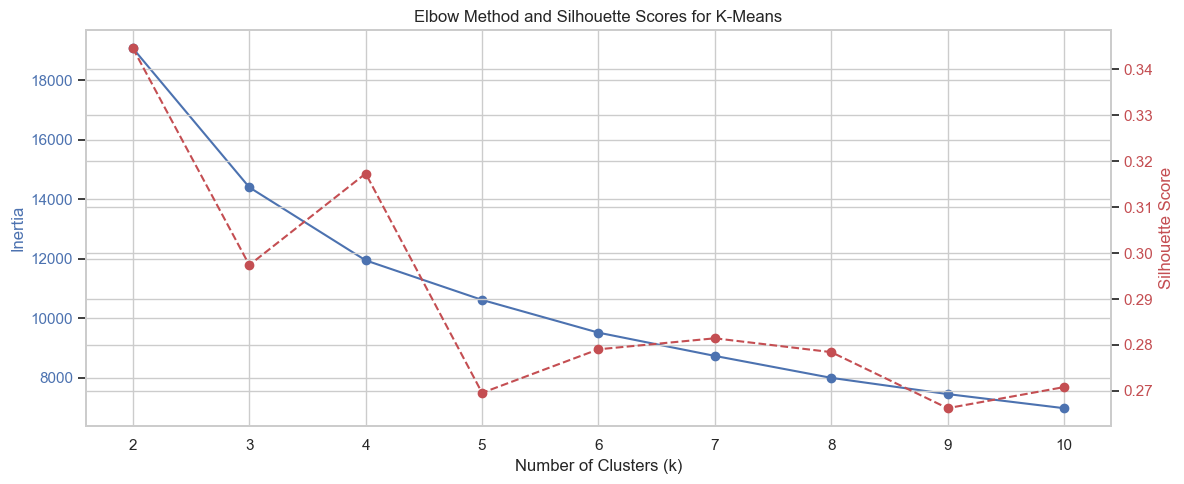

In [41]:
# ELBOW METHOD AND SILHOUETTE SCORES FOR K-MEANS
# Compute inertia and silhouette scores for different k values to determine optimal clusters
inertia = []
kmeans_silhouette_scores = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    kmeans_silhouette_scores.append(silhouette_score(df_scaled, labels))

kmeans_results = pd.DataFrame({
    "k": list(K_range),
    "Inertia": inertia,
    "Silhouette": kmeans_silhouette_scores
})

print("K-Means Results for different k:")
display(kmeans_results)

# ELBOW PLOT Y SILHOUETTE SCORE
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(K_range, inertia, 'bo-', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(K_range, kmeans_silhouette_scores, 'ro--', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Elbow Method and Silhouette Scores for K-Means')

fig.tight_layout()
plt.show()

#### **Interpretation:** 

The elbow in the inertia curve occurs around **k = 4**, where adding more clusters leads to much smaller decreases in inertia. The silhouette scores are also relatively high for **k = 3 – 4** and then drop.


### **Section 7: Final Cluster Selection**

**Chosen number of clusters:** `k = 5`.

**Justification**

1. **Elbow Plot (K-Means)**  
   - The inertia curve shows a steep drop from `k = 2` → `k = 3`, and it continues to decrease substantially up to `k = 4`.  
   - Moving from `k = 4` to `k = 5` still provides a non-trivial reduction in inertia, indicating that the model continues capturing meaningful structure when subdividing into 5 groups.
   - Beyond `k = 5`, the marginal gains in inertia become progressively smaller.

2. **Silhouette Scores**  
   - The average *silhouette scores* for `k = 3` and `k = 4` are the highest, but `k = 5` maintains a reasonable value (0.27).  
   - In other words, `k = 5` slightly sacrifices cohesiveness/separation but remains well within an acceptable range for real-world retail data.

3. **Dendrogram (Ward linkage)**  
   - The dendrogram suggests a natural grouping between 4 and 5 clusters before the largest jumps in linkage distance.  
   - Cutting just below the height corresponding to 4 groups yields 5 clusters that remain well separated and structurally coherent with the hierarchical analysis.

4. **Business Considerations (Retail Segmentation)**  
   - Using **5 clusters** provides actionable granularity by distinguishing:  
     - high-value loyal customers
     - low-spend browsers at risk 
     - new low-engagement customers
     - big-basket shoppers with high return rates 
     - mid-spenders with strong digital engagement 
   - This segmentation enables targeted CRM and marketing strategies, even if it slightly lowers the silhouette score.

In summary, although `k = 4` achieves slightly better statistical metrics, **we select `k = 5`** because it offers the best balance between clustering quality and business usefulness for a retail context.

### **Section 8: Apply Final K-Means Model**

In [42]:
# FIT K-MEANS
# Apply K-Means clustering with the chosen number of clusters
optimal_k = 5
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(df_scaled)

# EXTRACT CLUSTER LABELS AND CLUSTER SIZES
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = pd.DataFrame({'Cluster': unique, 'Count': counts})
cluster_sizes['Percentage'] = (cluster_sizes['Count'] / cluster_sizes['Count'].sum()) * 100

print("Cluster Distribution (k = 5):")
display(cluster_sizes)

# Average silhouette score for the chosen k
avg_silhouette = silhouette_score(df_scaled, cluster_labels)
print(f"Average silhouette score for k = {optimal_k}: {avg_silhouette:.3f}")

Cluster Distribution (k = 5):


,Cluster,Count,Percentage
0,0,522,17.400000
1,1,694,23.133333
2,2,428,14.266667
3,3,598,19.933333
4,4,758,25.266667


Average silhouette score for k = 5: 0.270


### **Section 9: Cluster Profiling and Interpretation**

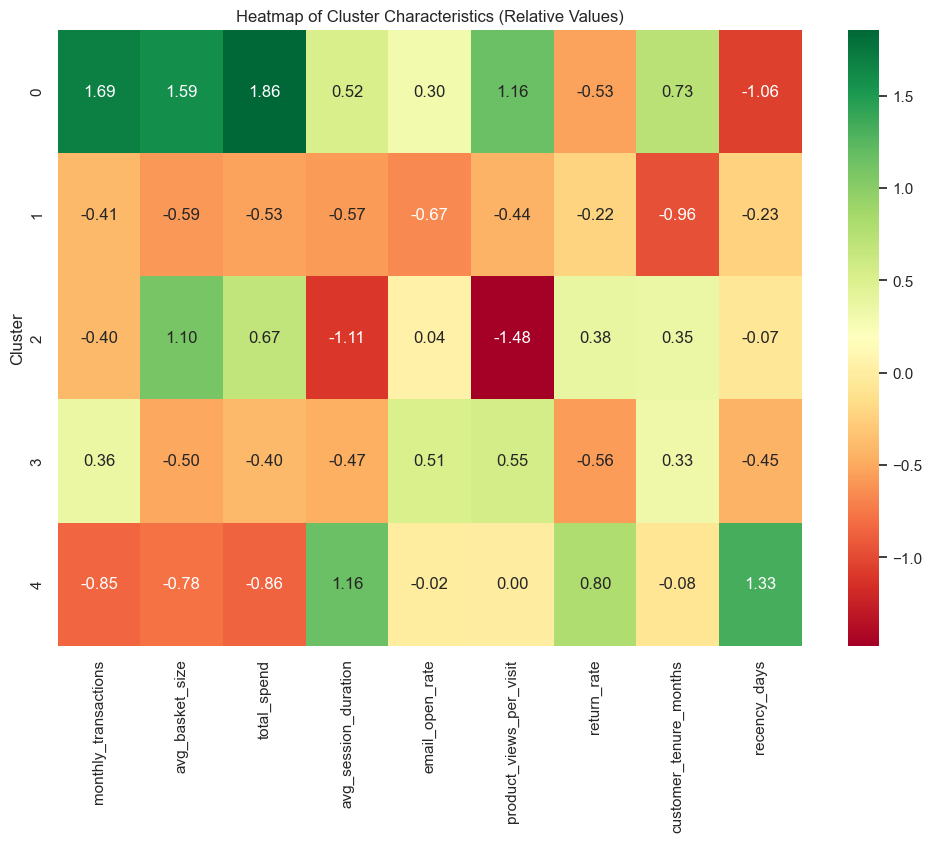

Cluster Profiles (Actual Values):


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
Cluster,,,,,,,,,
0,14.08,22.12,6541.68,45.91,0.57,42.94,0.10,26.08,7.94
1,4.05,4.78,1169.29,30.31,0.16,26.94,0.15,7.13,17.87
2,4.09,18.24,3882.35,22.49,0.46,16.63,0.25,21.84,19.87
3,7.75,5.49,1472.51,31.71,0.66,36.87,0.09,21.66,15.30
4,1.96,3.30,440.20,55.06,0.44,31.40,0.32,16.99,36.73


In [43]:
# ADD CLUSTERS TO ORIGINAL DATA
# Assign cluster labels to the original dataframe for profiling
df_analysis = df.copy()
df_analysis['Cluster'] = cluster_labels

# CALCULATE CLUSTER MEANS
cluster_profiles = df_analysis.groupby('Cluster').mean()

cluster_profiles_scaled = df_scaled.copy()
cluster_profiles_scaled['Cluster'] = cluster_labels
cluster_profiles_scaled = cluster_profiles_scaled.groupby('Cluster').mean()

# HEATMAP
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles_scaled, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Heatmap of Cluster Characteristics (Relative Values)')
plt.show()

print("Cluster Profiles (Actual Values):")
display(cluster_profiles.round(2))

#### **CHARACTERIZATION**

---
**Cluster 0 – High-Value Loyalists (~17% of customers)**  
- **Transactions & spending:** Very high purchase frequency (~14 transactions/month), large baskets (~22 items), and extremely high spending (~$6,540).  
- **Digital behavior:** Long sessions and high product exploration; above-average email engagement (~0.57).  
- **Relationship & risk:** Long tenure (~26 months), low recency (~8 days), and low return rate (~0.10).  
- **Interpretation:** These are the **VIP clients**, frequent purchasers with large baskets, high lifetime value, and low returns.

---


**Cluster 1 – New Low-Engagement Shoppers (~23% of customers)**  
- **Transactions & spending:** Fewer transactions (~4/month) and small baskets (~4.8 items), with lower-than-average total spend (~$1,170).  
- **Digital behavior:** Shorter sessions and fewer product views; very low email engagement (~0.16).  
- **Relationship & risk:** Short tenure (~7 months), meaning these customers are **fairly new**; moderate recency (~18 days); return rate slightly below average (~0.15).  
- **Interpretation:** They are **new or trial-phase customers** with low engagement.

---

**Cluster 2 – Big-Basket High-Spend Shoppers with Higher Returns (~14% of customers)**  
- **Transactions & spending:** Medium frequency (~4 transactions/month), but **very large baskets** (~18 items) and high total spend (~$3,880).  
- **Digital behavior:** Shorter sessions (~22 min) and fewer product views (~17), suggesting more intent-driven and planned purchasing.  
- **Relationship & risk:** Long tenure (~22 months), average recency (~20 days), but a high return rate (~0.25).  
- **Interpretation:** Customers who make **large, high-value purchases** but tend to return more items.

---

**Cluster 3 – Engaged Mid-Spend Loyalists (~20% of customers)**  
- **Transactions & spending:** Above-average frequency (~7.8 transactions/month), smaller baskets (~5.5 items), and moderate total spend (~$1,470).  
- **Digital behavior:** Very strong digital engagement (email open rate ≈ 0.66).  
- **Relationship & risk:** Long tenure (~22 months), relatively low recency (~15 days), and low return rate (~0.09).  
- **Interpretation:** They are **loyal customers with high digital engagement**, but moderate ticket sizes.

---

**Cluster 4 – Low-Spend Browsers at Risk (~25% of customers)**  
- **Transactions & spending:** Very few monthly transactions (~2 transactions/month), small baskets (~3 items), and low total spend (~$440).  
- **Digital behavior:** Long sessions and extensive browsing (avg. session ≈ 55 min).  
- **Relationship & risk:** Medium tenure (≈ 17 months), high recency (≈ 37 days), and an elevated return rate (~0.32).  
- **Interpretation:** Customers who **browse a lot but purchase very little**, with a notable inclination to return items.

---


### **Section 10: Cluster Validation - Silhouette Analysis**

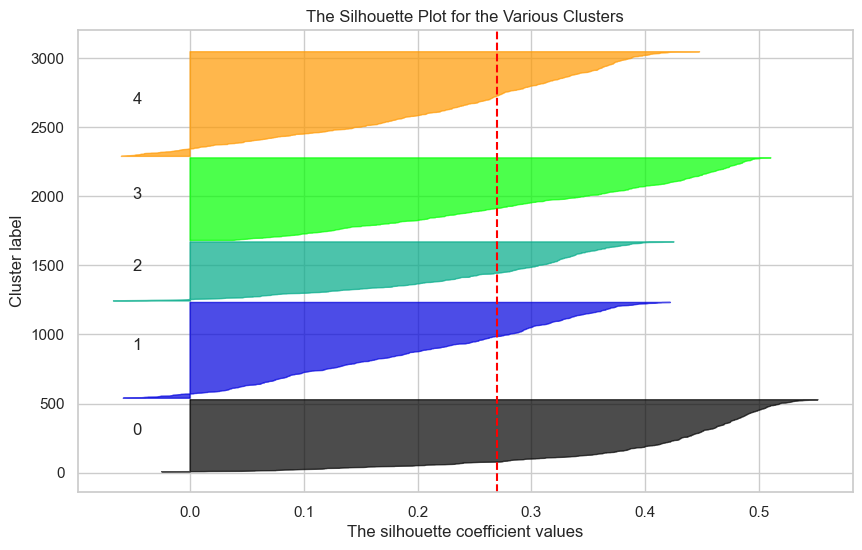

In [44]:
# SILHOUETTE PLOT
# Visualize the silhouette scores for each cluster to assess clustering quality
sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)

y_lower = 10
plt.figure(figsize=(10, 6))

for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10 

plt.title("The Silhouette Plot for the Various Clusters")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

plt.axvline(x=silhouette_score(df_scaled, cluster_labels), color="red", linestyle="--")
plt.show()

#### **INTERPRETATION**

- The average *silhouette score* for `k = 5` is ≈ **0.27**, which indicates a **reasonable level of separation** between clusters in the context of real customer data (which is not perfectly “spherical” and naturally contains noise and overlap).  
- There are no large amounts of points with negative silhouette values, suggesting that **very few customers would be better placed in a different cluster**; overall, the clustering structure is stable.  
- Compared with `k = 3` and `k = 4`, the silhouette score decreases slightly, but the **added business granularity** (being able to design targeted campaigns for five well-differentiated customer segments) compensates for this small statistical reduction.


### **Section 11: Cluster Visualization (PCA Projection)**

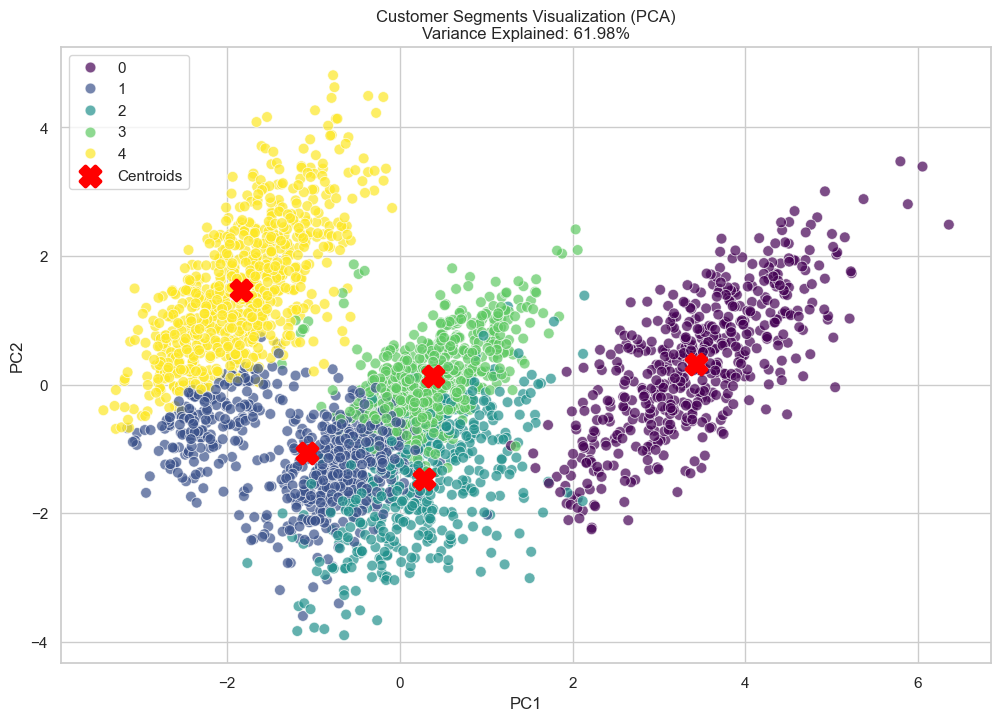

In [45]:
# APPLY PCA
# Reduce dimensionality to 2D for visualization using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = cluster_labels

# SCATTER PLOT
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=df_pca,
    palette='viridis',
    s=60, alpha=0.7
)

# ADD CENTROIDS
centers_df = pd.DataFrame(
    final_kmeans.cluster_centers_,
    columns=df_scaled.columns,
    index=np.unique(cluster_labels)
)

centroids = pca.transform(centers_df)

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=200,
    linewidths=3,
    color='red',
    label='Centroids'
)

# VARIANCE EXPLAINED
plt.title(f'Customer Segments Visualization (PCA)\nVariance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%')
plt.legend()
plt.show()

#### **LIMITATION**

This 2D scatterplot is a PCA projection, meaning it reduces the original 9 dimensional customer data into just two principal components (PC1 and PC2). While it helps us visually understand general separation between clusters, it cannot capture all the complexity of the true feature space.  

In reality, the clusters are formed using the full 9 dimensional structure, so some overlaps or distances seen here may look different when all variables are considered. The PCA view is useful for interpretation, but it is ultimately a simplified, lower-dimensional approximation of the real clustering.


### **Section 12: Technical Conclusion**

Our analysis initially showed that the best statistical indicators were concentrated around `k = 3` and `k = 4`, with average *silhouette scores* of approximately 0.30–0.32 and a clear inertia elbow near `k = 4`.  
However, after incorporating retail business considerations, we decided to **adopt a final segmentation with `k = 5` clusters**.

From a **technical perspective**:

- **Elbow & Inertia:**  
  - Inertia decreases sharply from `k = 2` to `k = 4`, and it continues to decline meaningfully when moving from `k = 4` to `k = 5`, indicating that the model is still capturing relevant structure.  
- **Silhouette Scores:**  
  - `k = 3` and `k = 4` achieve the highest silhouette values (≈ 0.30+), while `k = 5` maintains an acceptable value (≈ 0.27), still outperforming configurations with larger numbers of clusters.  
- **Consistency across methods:**  
  - The Ward linkage dendrogram also suggests that 4 or 5 groups are reasonable cut points, meaning the 5-cluster solution is consistent with both K-Means and the hierarchical analysis.

From a **business and actionability perspective**:

- With **3 clusters**, several distinct customer profiles (new customers, low spenders, deal hunters, average buyers) become mixed together, limiting the ability to design targeted campaigns.  
- With **5 clusters**, we obtain clearly differentiated segments:  
  - High-Value Loyalists
  - New Low-Engagement Shoppers
  - Big-Basket High-Spend Shoppers with Higher Returns 
  - Engaged Mid-Spend Loyalists,  
  - Low-Spend Browsers at Risk,  


In conclusion, although `k = 4` slightly maximizes the silhouette metric, the **`k = 5` solution provides a better balance between statistical quality and business value**, which is why we recommend these five segments as the final foundation for MegaMart’s marketing strategy.
